In [1]:
import os
# Enforces CPU-only execution of torch
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Configure environment to ensure single-threaded execution.
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"]= "1"
os.environ["OMP_NUM_THREADS"] = "1"

import torch
torch.set_num_threads(1)

from xtr.datasets import BEIR, BEIRDataset, LoTTE, LoTTEDataset
from xtr.config import XTRConfig, XTRModel, XTRScaNNIndexConfig, XTRBruteForceIndexConfig, XTRFAISSIndexConfig
from xtr.utils import xtr_tracker, canonical_index_name
from xtr.modeling.xtr import XTR

import json
from datetime import datetime

/future/u/scheerer/miniconda3/envs/xtr-eval/lib/python3.8/site-packages/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
NUM_QUERIES = 5
DOCUMENT_TOP_K = 100
TOKEN_TOP_K = 10_000

In [3]:
dataset = LoTTEDataset(dataset=LoTTE.LIFESTYLE, datasplit="test")
index_config = XTRScaNNIndexConfig()
index_name = canonical_index_name(dataset=dataset, index_config=index_config)
config = XTRConfig(index_name=index_name, model=XTRModel.BASE_EN, index_config=index_config, override=False)

xtr = XTR(config=config, collection=dataset.collection, device=torch.device("cpu"))

#> Loading collection from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/test/collection.tsv ...
0M 
#> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/test/questions.search.tsv ...
#> Got 661 queries. All QIDs are unique.
Loading existing index from /future/u/scheerer/home/data/xtr-eval/indexes/LoTTE.LIFESTYLE.search.split=test.XTRIndexType.SCANN.


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 38:5: text format contains deprecated field "min_cluster_size"


In [4]:
from xtr.data.queries import Queries
queries_test = Queries.cast(list(map(lambda x: x[1], dataset.queries))[:NUM_QUERIES])

In [5]:
from xtr.utils.tracker import ExecutionTracker

groups = {
    "Candidate Generation": ["search_batched", "enumerate_scores"],
    "Aggregate Scores": ["get_did2scores", "add_ems", "get_final_score", "sort_scores"]
}

tracker = ExecutionTracker(name=index_name, steps=["Query Encoding", "search_batched", "enumerate_scores", "Estimate Missing Similarity",
                                                   "get_did2scores", "add_ems", "get_final_score", "sort_scores"])
rankings = xtr.retrieve_docs(queries_test, document_top_k=DOCUMENT_TOP_K, token_top_k=TOKEN_TOP_K, tracker=tracker)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


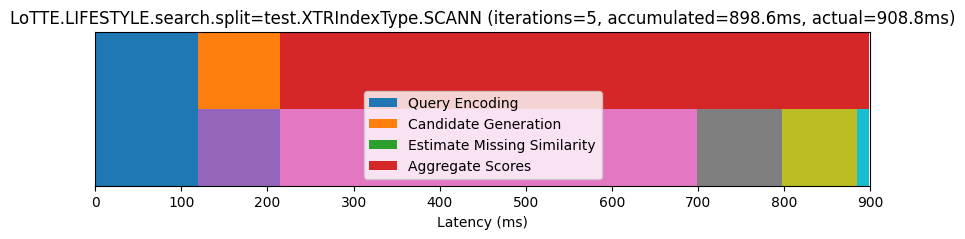

In [10]:
tracker.display_grouped(groups, detailed=True)

In [44]:
from tqdm import tqdm
# Additional Precomputation
ntokens = len(xtr.tid2did) - 1 # tid2did contains -1 for invalid
tid2did_vectorized = torch.zeros(ntokens, dtype=torch.int32)

for key, value in tqdm(xtr.tid2did.items()):
    if key == -1:
        continue
    tid2did_vectorized[key] = value

100%|████████████████████████████████████████████████████████████████████████████████████| 23713178/23713178 [01:32<00:00, 256085.15it/s]


In [45]:
tid2did_vectorized[100_000]

tensor(814, dtype=torch.int32)

In [46]:
xtr.tid2did[100_000]

814

In [75]:
import torch
import numpy as np

from torch_scatter import scatter_max

def _aggregate_scores(self, batch_result, batch_ems, document_top_k, tracker):
    """Aggregates token-level retrieval scores into query-document scores."""
    assert len(batch_result) == 1 and len(batch_ems) == 1

    # TODO(jlscheerer) this is an extremely weird way of storing this!
    # neighbors: (ntokens, token_top_k), represents the token_ids of the retrieved "candidates"
    query_tokens, neighbors, scores = batch_result[0]

    assert neighbors.shape == scores.shape
    ntokens, token_top_k = neighbors.shape
    
    # Total number of unique documents.
    candidate_dids = tid2did_vectorized[neighbors]
    idx_to_candidate_did = torch.unique(candidate_dids.flatten(), sorted=True)
    ncandidates = idx_to_candidate_did.shape[0]

    # Construct a tensor indicating the qtoken_idx for each candidate.
    candidate_qids = torch.repeat_interleave(torch.arange(ntokens), token_top_k)

    # Construct a tensor indicating the index corresponding to each of the candidate document ids.
    candidate_dids_idx = torch.searchsorted(idx_to_candidate_did, candidate_dids.flatten())

    # *Exact* index into the flattened score matrix for (candidate_did, token_idx)
    indices = candidate_dids_idx * self.config.query_maxlen + candidate_qids

    # The score_matrix corresponds to did2scores dictionary.
    score_matrix = torch.zeros((ncandidates, self.config.query_maxlen), dtype=torch.float)

    # Populate the score matrix using the maximum value for each index.
    flat_score_matrix, _ = scatter_max(torch.from_numpy(scores.flatten()), indices, out=score_matrix.view(-1))
    score_matrix = flat_score_matrix.view(score_matrix.size())

    tracker.begin("get_did2scores")
    def get_did2scores(query_tokens, all_neighbors, all_scores):
        did2scores = {}
        # |Q| x k'
        for qtoken_idx, (qtoken, neighbors, scores) in enumerate(zip(query_tokens, all_neighbors, all_scores)):
            for _, (doc_token_id, score) in enumerate(zip(neighbors, scores)):
                if np.isnan(score):
                    continue
                docid = self.tid2did[doc_token_id]
                if docid not in did2scores:
                    did2scores[docid] = {}
                qtoken_with_idx = (qtoken_idx, qtoken)
                if qtoken_with_idx not in did2scores[docid]:
                    # Only keep the top score for sum-of-max.
                    did2scores[docid][qtoken_with_idx] = score

        # print(did2scores[3411])
        # idx = (idx_to_candidate_did == 3411).nonzero(as_tuple=True)[0][0]
        # print(score_matrix[idx])
        
        return did2scores

    batch_did2scores = [get_did2scores(qtokens, neighbors, scores) for qtokens, neighbors, scores in batch_result]
    tracker.end("get_did2scores")

    tracker.begin("add_ems")
    def add_ems(did2scores, query_tokens, ems):
        # |Q| x |Q|k' (assuming most docid is unique)
        for qtoken_idx, qtoken in enumerate(query_tokens):
            qtoken_with_idx = (qtoken_idx, qtoken)
            for _, scores in did2scores.items():
                if qtoken_with_idx not in scores:
                    scores[qtoken_with_idx] = ems[qtoken_with_idx]

    for did2scores, result, ems in zip(batch_did2scores, batch_result, batch_ems):
        add_ems(did2scores, result[0], ems)
    tracker.end("add_ems")

    tracker.begin("get_final_score")
    def get_final_score(did2scores, query_tokens):
        final_qd_score = {}
        # |Q|k' x |Q|
        for docid, scores in did2scores.items():
            assert len(scores) == len(query_tokens)
            final_qd_score[docid] = sum(scores.values()) / len(scores)
        return final_qd_score

    batch_scores = [get_final_score(did2scores, result[0]) for did2scores, result in zip(batch_did2scores, batch_result)]
    tracker.end("get_final_score")

    tracker.begin("sort_scores")
    batch_ranking = [
        sorted([(docid, score) for docid, score in final_qd_score.items()], key=lambda x: x[1], reverse=True)[:document_top_k]
        for final_qd_score in batch_scores
    ]
    tracker.end("sort_scores")
    return batch_ranking

xtr._aggregate_scores = lambda *args, **kwargs: _aggregate_scores(xtr, *args, **kwargs)

tracker = ExecutionTracker(name=index_name, steps=["Query Encoding", "search_batched", "enumerate_scores", "Estimate Missing Similarity",
                                                   "get_did2scores", "add_ems", "get_final_score", "sort_scores"])
rankings = xtr.retrieve_docs(queries_test, document_top_k=DOCUMENT_TOP_K, token_top_k=TOKEN_TOP_K, tracker=tracker)

  0%|                                                                                                              | 0/5 [00:00<?, ?it/s]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5287, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
{(0, 'q_0'): 0.89094603, (2, 'q_2'): 0.77501607, (3, 'q_3'): 0.61859125, (4, 'q_4'): 0.7008115, (5, 'q_5'): 0.5801127, (6, 'q_6'): 0.6645701, (7, 'q_7'): 0.5125997, (8, 'q_8'): 0.7666612, (9, 'q_9'): 0.8135221, (10, 'q_10'): 0.8599292, (11, 'q_11'): 0.6368538, (12, 'q_12'): 0.83509326, (13, 'q_13'): 0.8450404}
tensor([0.8909, 0.0000, 0.7750, 0.6186, 0.7008, 0.5801, 0.6646, 0.5126, 0.7667,
        0.8135, 0.8599, 0.6369, 0.8351, 0.8450, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


 20%|████████████████████▍                                                                                 | 1/5 [00:01<00:04,  1.07s/it]

tensor([[0.0000, 0.8072, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7186,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


 20%|████████████████████▍                                                                                 | 1/5 [00:01<00:06,  1.71s/it]


KeyError: 3411

In [9]:
dataset.eval(rankings)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



{'Success@5': 0.7564296520423601}